In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp

# Q1
## (a)

In [39]:
mask = pd.read_csv('mask.csv')
mask.columns = mask.iloc[0]
mask.drop(mask.index[0], inplace=True)
mask.columns = mask.columns.str.strip()

In [40]:
y = mask.iloc[:, 0].values.astype(float)
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 251. 250. ...   1.   0.  -0.]
 [  1. 252. 251. ...   2.   1.   0.]
 [  1. 253. 252. ...   3.   2.   1.]]


In [11]:
#below penalty_start = 2 means that b0 and b1 are not included in the penalty
def solve_ridge(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

def solve_lasso(X, y, lambda_val, penalty_start=2):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

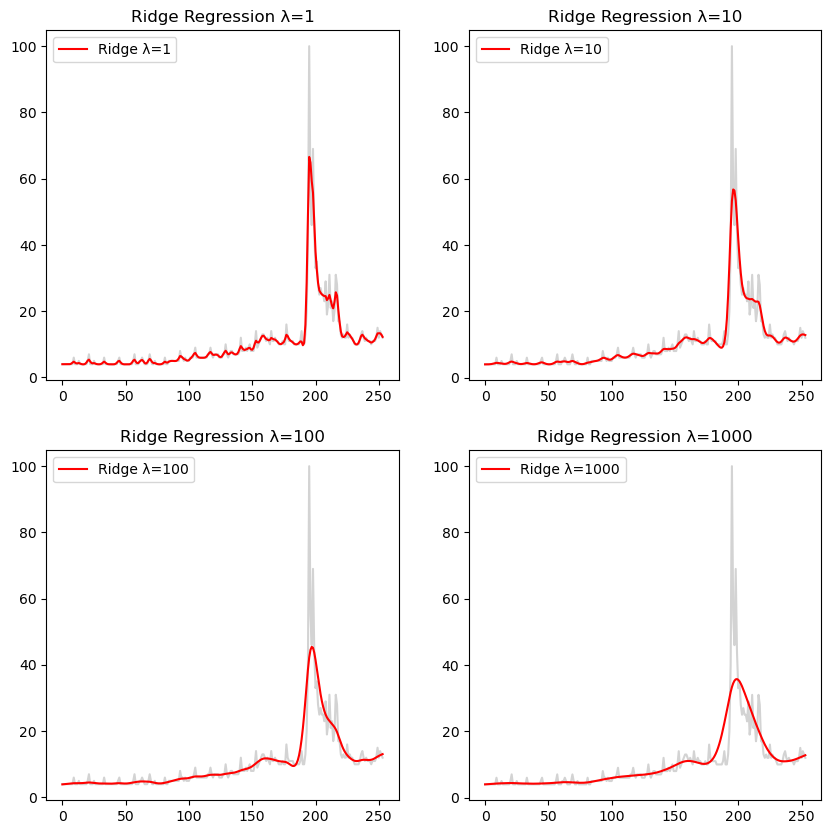

In [42]:
lambda_vals = [1, 10, 100, 1000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, lambda_val in enumerate(lambda_vals):
    b_ridge = solve_ridge(Xfull, y, lambda_val=lambda_val)
    ridge_fitted = np.dot(Xfull, b_ridge)
    ax_idx = (idx // 2, idx % 2)
    ax[ax_idx].plot(y, color='lightgray')
    ax[ax_idx].plot(ridge_fitted, color='red', label=f'Ridge λ={lambda_val}')
    ax[ax_idx].legend()
    ax[ax_idx].set_title(f'Ridge Regression λ={lambda_val}')
plt.show()

### Comparison and Interpretation of Trend Estimates
When λ is small (like λ = 1), the model is more flexible and can capture small, short-term oscillations in the data. This is because a small λ allows the model to fit the data more closely, 
resulting in a delicate fitted trend line that follows the data points more closely. As λ grows higher, the model becomes less flexible and the fitted trend line becomes smoother,
resulting in a more general trend that may not capture small fluctuations in the data. The peak amplitude of the fitted trend line also decreases as λ increases. The sharpness of 
the peak of attenuates following big λ like 100 and 1000.
 
λ=1 is the most suitable choice for the Ridge Regression model in this case, because it can best capture small, short-term oscillations in the data,
and it could also capture the amplitude of sharp peaks in the data.

## (b)

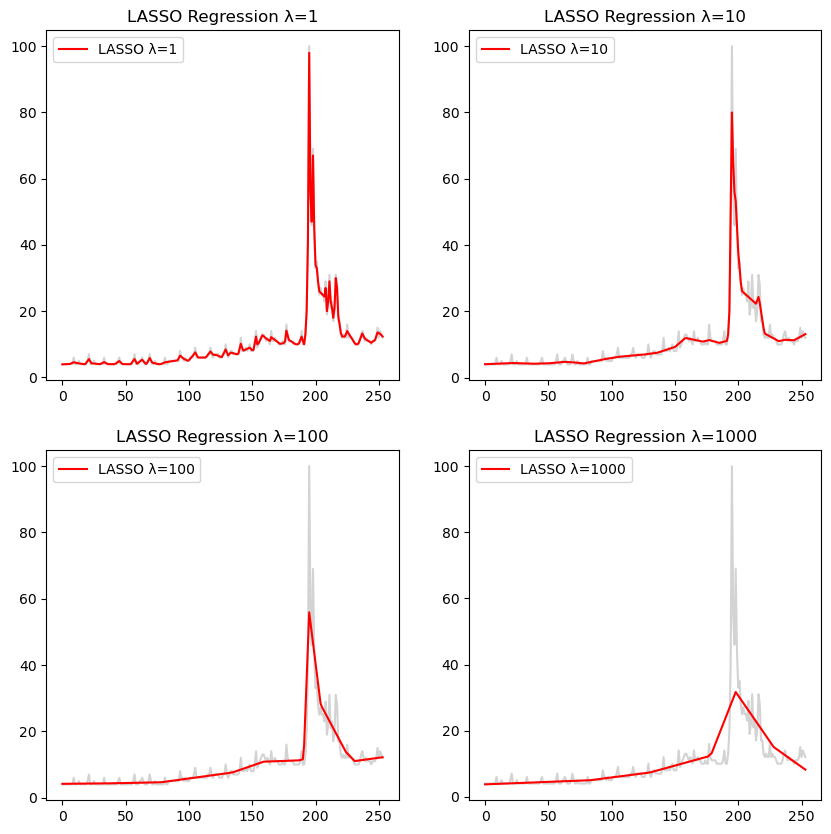

In [45]:
lambda_vals = [1, 10, 100, 1000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, lambda_val in enumerate(lambda_vals):
    b_ridge = solve_lasso(Xfull, y, lambda_val=lambda_val)
    lasso_fitted = np.dot(Xfull, b_ridge)
    ax_idx = (idx // 2, idx % 2)
    ax[ax_idx].plot(y, color='lightgray')
    ax[ax_idx].plot(lasso_fitted, color='red', label=f'LASSO λ={lambda_val}')
    ax[ax_idx].legend()
    ax[ax_idx].set_title(f'LASSO Regression λ={lambda_val}')
plt.show()

### Comparison and Interpretation of LASSO Trend Estimates
When λ is small like 1 and 10, it could capture both the amplitude of sharp peaks in the data and the short term oscillation. While for λ = 100 or 1000, 
the fitted line become smoother, where both the oscillation and the amplitude of sharp peaks are not captured well.


The LASSO model with λ=1 is the most suitable choice for the LASSO model in this case, because just
like the Ridge counterpart, it can best capture small, short-term oscillations in the data as well as the amplitude of sharp peaks in the data.
It also performs better than the last three models in terms of capturing aftermath oscillation following the highest peak.

## (c)

In [10]:
def ridge_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

def lasso_cv(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_lasso(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [23]:
lambda_candidates = np.array([1, 10, 100, 1000])
print(lambda_candidates)

best_lambda1, cv_errors1 = lasso_cv(Xfull, y, lambda_candidates)
print("best lambda for lasso:", best_lambda1)
print("LASSO: CV errors for each lambda:")
for lamb, error in sorted(cv_errors1.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


best_lambda2, cv_errors2 = ridge_cv(Xfull, y, lambda_candidates)
print("best lambda for ridge:", best_lambda2)
print("Ridge: CV errors for each lambda:")
for lamb, error in sorted(cv_errors2.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")   


[   1   10  100 1000]
best lambda for lasso: 1
LASSO: CV errors for each lambda:
Lambda = 1.00, CV Error = 19.138592
Lambda = 10.00, CV Error = 22.843728
Lambda = 100.00, CV Error = 25.767100
Lambda = 1000.00, CV Error = 43.715336
best lambda for ridge: 1
Ridge: CV errors for each lambda:
Lambda = 1.00, CV Error = 21.723619
Lambda = 10.00, CV Error = 21.878046
Lambda = 100.00, CV Error = 27.183944
Lambda = 1000.00, CV Error = 35.545907


According to the outcome of cross validation, LASSO regression with $\lambda = 1$ may be the optimal choice for the least cross validation error.

# Q2

In [24]:
wage = pd.read_csv('minWage.csv')

In [25]:
wage.head()

,observation_date,FEDMINNFRWG
0,1938-10-01,0.25
1,1938-11-01,0.25
2,1938-12-01,0.25
3,1939-01-01,0.25
4,1939-02-01,0.25


In [46]:
# t = wage['observation_date']
y = wage['FEDMINNFRWG']
n = len(y)

In [47]:
X = np.tril(np.ones((n, n)), k = 0)

In [35]:
#regularization starts at b1
def solve_ridge1(X, y, lambda_val, penalty_start = 1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.sum_squares(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

def solve_lasso1(X, y, lambda_val, penalty_start = 1):
    n, p = X.shape
    
    # Define variable
    beta = cp.Variable(p)
    
    # Define objective
    loss = cp.sum_squares(X @ beta - y)
    reg = lambda_val * cp.norm1(beta[penalty_start:])
    objective = cp.Minimize(loss + reg)
    
    # Solve problem
    prob = cp.Problem(objective)
    prob.solve()
    
    return beta.value

In [37]:
def ridge_cv1(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_ridge1(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

def lasso_cv1(X, y, lambda_candidates):
    n = len(y)
    folds = []
    for i in range(5):
        test_indices = np.arange(i, n, 5)
        train_indices = np.array([j for j in range(n) if j % 5 != i])
        folds.append((train_indices, test_indices))
    cv_errors = {lamb: 0 for lamb in lambda_candidates}

    for train_index, test_index in folds:
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        for lamb in lambda_candidates:
            beta = solve_lasso1(X_train, y_train, lambda_val = lamb)
            y_pred = np.dot(X_test, beta)
            squared_errors = (y_test - y_pred) ** 2
            cv_errors[lamb] += np.sum(squared_errors)
    for lamb in lambda_candidates:
        cv_errors[lamb] /= n
        
    best_lambda = min(cv_errors, key = cv_errors.get)

    return best_lambda, cv_errors

In [38]:
lambda_candidates = np.array([1, 10, 100, 1000])
print(lambda_candidates)

best_lambda1, cv_errors1 = lasso_cv(X, y, lambda_candidates)
print("best lambda for lasso:", best_lambda1)
print("LASSO: CV errors for each lambda:")
for lamb, error in sorted(cv_errors1.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")


best_lambda2, cv_errors2 = ridge_cv(X, y, lambda_candidates)
print("best lambda for ridge:", best_lambda2)
print("Ridge: CV errors for each lambda:")
for lamb, error in sorted(cv_errors2.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")   


[   1   10  100 1000]
best lambda for lasso: 1
LASSO: CV errors for each lambda:
Lambda = 1.00, CV Error = 0.001521
Lambda = 10.00, CV Error = 0.002161
Lambda = 100.00, CV Error = 0.047861
Lambda = 1000.00, CV Error = 2.402223
best lambda for ridge: 1
Ridge: CV errors for each lambda:
Lambda = 1.00, CV Error = 0.001749
Lambda = 10.00, CV Error = 0.002867
Lambda = 100.00, CV Error = 0.007495
Lambda = 1000.00, CV Error = 0.033357


## (a)

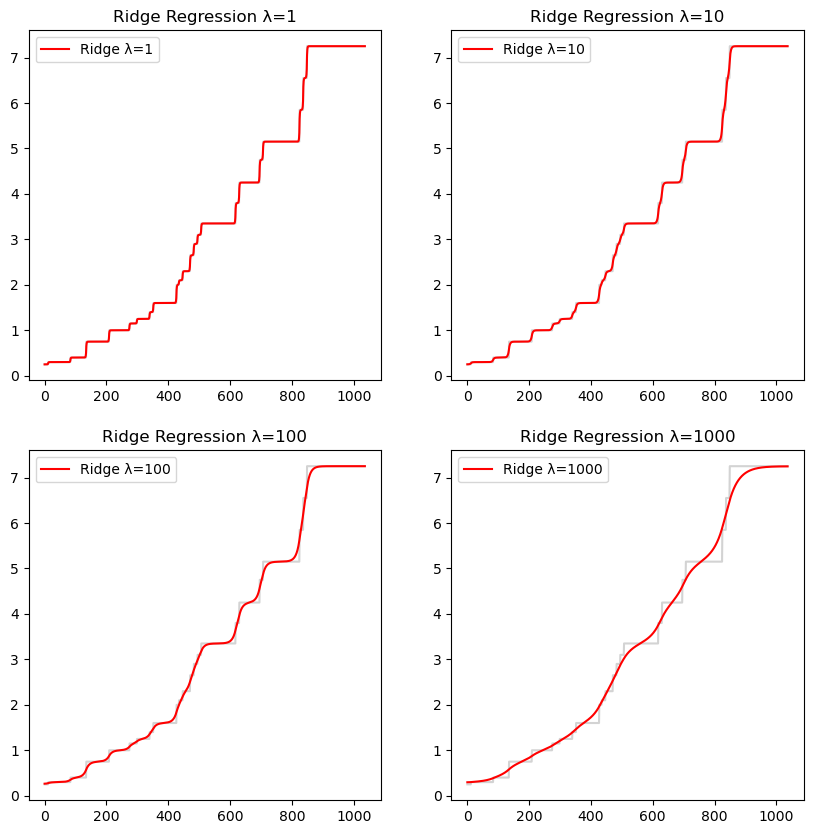

In [36]:
lambda_vals = [1, 10, 100, 1000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, lambda_val in enumerate(lambda_vals):
    b_ridge = solve_ridge1(X, y, lambda_val=lambda_val)
    ridge_fitted = np.dot(X, b_ridge)
    ax_idx = (idx // 2, idx % 2)
    ax[ax_idx].plot(y, color='lightgray')
    ax[ax_idx].plot(ridge_fitted, color='red', label=f'Ridge λ={lambda_val}')
    ax[ax_idx].legend()
    ax[ax_idx].set_title(f'Ridge Regression λ={lambda_val}')
plt.show()

When λ = 1 and 10, the fitted line could capture the original data nearly perfect, while as λ grows higher to 100 and 1000, the fitted 
line become smoother, fail to capture much of the piece-wise constant part of the data.

λ = 1 provides the best summary of the data given its perfect fitted line and the least cross validation error across all four λ.

## (b)

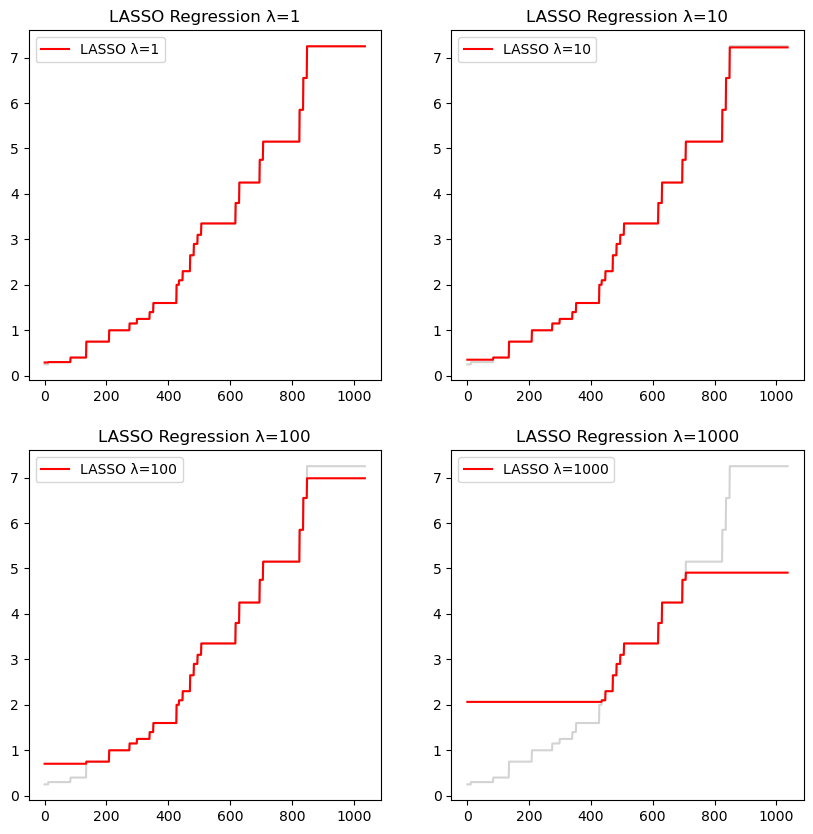

In [48]:
lambda_vals = [1, 10, 100, 1000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for idx, lambda_val in enumerate(lambda_vals):
    b_ridge = solve_lasso1(X, y, lambda_val=lambda_val)
    lasso_fitted = np.dot(X, b_ridge)
    ax_idx = (idx // 2, idx % 2)
    ax[ax_idx].plot(y, color='lightgray')
    ax[ax_idx].plot(lasso_fitted, color='red', label=f'LASSO λ={lambda_val}')
    ax[ax_idx].legend()
    ax[ax_idx].set_title(f'LASSO Regression λ={lambda_val}')
plt.show()

When λ = 1 and 10, the fitted line could capture the original data nearly perfectly, while as λ grows higher to 100 and 1000, much of 
the parameters are set to 0 and hence the model lose precision, failing to capture much of the piece-wise constant part of the data.

λ = 1 provides the best summary of the data given its perfect fitted line and the least cross-validation error across all four λ.

## (c)
LASSO regression with λ = 1 is the best fit given its minimal cross validation error within the eight choices. Also, it captures the sharp jump
from one piecewise constant period to another better than its λ = 1 counterpart in ridge regression.

# Q3
## Ridge and Lasso Regression Coefficients

Consider a univariate regression dataset $(x_1, y_1), \ldots, (x_n, y_n)$, where each $x_i$ and $y_i$ are real-valued, and fix $\lambda > 0$. Define $\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i$ and $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$.

### (a) Ridge Regression

We need to show that the coefficients $(\hat{\beta}_{\text{ridge},0}(\lambda), \hat{\beta}_{\text{ridge},1}(\lambda))$ minimizing

$$
\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i)^2 + \lambda \beta_1^2
$$

over all $\beta_0, \beta_1$ are:

$$
\hat{\beta}_{\text{ridge},1}(\lambda) = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\lambda + \sum_{i=1}^n (x_i - \bar{x})^2},
$$

$$
\hat{\beta}_{\text{ridge},0}(\lambda) = \bar{y} - \bar{x} \hat{\beta}_{\text{ridge},1}(\lambda).
$$

The objective function is:

$$
J(\beta_0, \beta_1) = \sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i)^2 + \lambda \beta_1^2.
$$

Compute the partial derivative with respect to $\beta_0$:

$$
\frac{\partial J}{\partial \beta_0} = -2 \sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i).
$$

Set to zero:

$$
\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i) = 0,
$$

$$
\sum_{i=1}^n y_i - n \beta_0 - \beta_1 \sum_{i=1}^n x_i = 0,
$$

$$
\beta_0 = \bar{y} - \beta_1 \bar{x}.
$$

Thus:

$$
\hat{\beta}_{\text{ridge},0}(\lambda) = \bar{y} - \bar{x} \hat{\beta}_{\text{ridge},1}(\lambda).
$$

Now compute the partial derivative with respect to $\beta_1$:

$$
\frac{\partial J}{\partial \beta_1} = -2 \sum_{i=1}^n x_i (y_i - \beta_0 - \beta_1 x_i) + 2 \lambda \beta_1.
$$

Set to zero:

$$
\sum_{i=1}^n x_i (y_i - \beta_0 - \beta_1 x_i) = \lambda \beta_1.
$$

Substitute $\beta_0 = \bar{y} - \beta_1 \bar{x}$:

$$
\sum_{i=1}^n x_i \left( y_i - (\bar{y} - \beta_1 \bar{x}) - \beta_1 x_i \right) = \lambda \beta_1,
$$

$$
\sum_{i=1}^n x_i \left[ (y_i - \bar{y}) - \beta_1 (x_i - \bar{x}) \right] = \lambda \beta_1,
$$

$$
\sum_{i=1}^n x_i (y_i - \bar{y}) - \beta_1 \sum_{i=1}^n x_i (x_i - \bar{x}) = \lambda \beta_1.
$$

Since $\sum_{i=1}^n (x_i - \bar{x}) = 0$,

$$
\sum_{i=1}^n x_i (x_i - \bar{x}) = \sum_{i=1}^n (x_i - \bar{x})^2,
$$

$$
\sum_{i=1}^n x_i (y_i - \bar{y}) = \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}),
$$

so:

$$
\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) - \beta_1 \sum_{i=1}^n (x_i - \bar{x})^2 = \lambda \beta_1,
$$

$$
\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) = \beta_1 \left( \sum_{i=1}^n (x_i - \bar{x})^2 + \lambda \right),
$$

$$
\beta_1 = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\lambda + \sum_{i=1}^n (x_i - \bar{x})^2}.
$$

Thus:

$$
\hat{\beta}_{\text{ridge},1}(\lambda) = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\lambda + \sum_{i=1}^n (x_i - \bar{x})^2},
$$

and the expressions are verified.

### (b) Lasso Regression

We need to show that the coefficients $(\hat{\beta}_{\text{lasso},0}(\lambda), \hat{\beta}_{\text{lasso},1}(\lambda))$ minimizing

$$
\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i)^2 + \lambda |\beta_1|
$$

over all $\beta_0, \beta_1$ are:

$$
\hat{\beta}_{\text{lasso},0}(\lambda) = \bar{y} - \bar{x} \hat{\beta}_{\text{lasso},1}(\lambda),
$$

$$
\hat{\beta}_{\text{lasso},1}(\lambda) =
\begin{cases}
\frac{\sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) - \lambda/2}{\sum_{i=1}^n (x_i - \bar{x})^2} & \text{if } \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) > \lambda/2, \\
\frac{\sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) + \lambda/2}{\sum_{i=1}^n (x_i - \bar{x})^2} & \text{if } \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) < -\lambda/2, \\
0 & \text{if } -\lambda/2 \leq \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) \leq \lambda/2.
\end{cases}
$$

The objective function is:

$$
J(\beta_0, \beta_1) = \sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i)^2 + \lambda |\beta_1|.
$$

Compute the partial derivative with respect to $\beta_0$:

$$
\frac{\partial J}{\partial \beta_0} = -2 \sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i).
$$

Set to zero:

$$
\sum_{i=1}^n (y_i - \beta_0 - \beta_1 x_i) = 0,
$$

$$
\beta_0 = \bar{y} - \beta_1 \bar{x}.
$$

Thus:

$$
\hat{\beta}_{\text{lasso},0}(\lambda) = \bar{y} - \bar{x} \hat{\beta}_{\text{lasso},1}(\lambda).
$$

Substitute $\beta_0 = \bar{y} - \beta_1 \bar{x}$:

$$
J(\beta_1) = \sum_{i=1}^n \left[ (y_i - \bar{y}) - \beta_1 (x_i - \bar{x}) \right]^2 + \lambda |\beta_1|,
$$

$$
= \sum_{i=1}^n (y_i - \bar{y})^2 - 2 \beta_1 \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) + \beta_1^2 \sum_{i=1}^n (x_i - \bar{x})^2 + \lambda |\beta_1|.
$$

Define:

$$
S = \sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}), \quad V = \sum_{i=1}^n (x_i - \bar{x})^2,
$$

so:

$$
J(\beta_1) = V \beta_1^2 - 2 S \beta_1 + \lambda |\beta_1| + \text{constant}.
$$

Minimize by cases:

- For $\beta_1 > 0$, $J(\beta_1) = V \beta_1^2 - 2 S \beta_1 + \lambda \beta_1$,

$$
\frac{dJ}{d\beta_1} = 2 V \beta_1 + \lambda - 2 S = 0,
$$

$$
\beta_1 = \frac{S - \lambda/2}{V}, \quad \text{valid if } S > \lambda/2.
$$

- For $\beta_1 < 0$, $J(\beta_1) = V \beta_1^2 - 2 S \beta_1 - \lambda \beta_1$,

$$
\frac{dJ}{d\beta_1} = 2 V \beta_1 - 2 S - \lambda = 0,
$$

$$
\beta_1 = \frac{S + \lambda/2}{V}, \quad \text{valid if } S < -\lambda/2.
$$

- At $\beta_1 = 0$, $J(0) = 0$.

If $-\lambda/2 \leq S \leq \lambda/2$, the minimum is at $\beta_1 = 0$ since $J(\beta_1) \geq 0$ elsewhere. Thus:

$$
\hat{\beta}_{\text{lasso},1}(\lambda) =
\begin{cases}
\frac{S - \lambda/2}{V} = \frac{\sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) - \lambda/2}{\sum_{i=1}^n (x_i - \bar{x})^2} & \text{if } S > \lambda/2, \\
\frac{S + \lambda/2}{V} = \frac{\sum_{i=1}^n (y_i - \bar{y})(x_i - \bar{x}) + \lambda/2}{\sum_{i=1}^n (x_i - \bar{x})^2} & \text{if } S < -\lambda/2, \\
0 & \text{if } -\lambda/2 \leq S \leq \lambda/2,
\end{cases}
$$

matching the required expression.

# Q4
## (a)

In [217]:
yahoo = pd.read_csv('yahoo.csv')

In [218]:
yahoo.drop(yahoo.index[0], inplace=True)

In [219]:
yahoo.iloc[:,0]

2004-01    39
2004-02    39
2004-03    39
2004-04    40
2004-05    43
           ..
2024-11    16
2024-12    16
2025-01    16
2025-02    16
2025-03    16
Name: 类别：所有类别, Length: 255, dtype: object

In [220]:
y = yahoo.iloc[:, 0].values.astype(float)
n = len(y)
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 252. 251. ...   1.   0.  -0.]
 [  1. 253. 252. ...   2.   1.   0.]
 [  1. 254. 253. ...   3.   2.   1.]]


In [221]:
lambda_candidates = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
print(lambda_candidates)

best_lambda1, cv_errors1 = ridge_cv(Xfull, y, lambda_candidates)
print("best lambda for ridge:", best_lambda1)
print("Ridge: CV errors for each lambda:")
for lamb, error in sorted(cv_errors1.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
best lambda for ridge: 1.0
Ridge: CV errors for each lambda:
Lambda = 0.00, CV Error = 4.649718
Lambda = 0.00, CV Error = 4.647731
Lambda = 0.01, CV Error = 4.627829
Lambda = 0.10, CV Error = 4.444494
Lambda = 1.00, CV Error = 4.026708
Lambda = 10.00, CV Error = 4.379094
Lambda = 100.00, CV Error = 5.664192
Lambda = 1000.00, CV Error = 7.554835
Lambda = 10000.00, CV Error = 9.686066


here I choose λ equals 1 given its smallest cross validation error.

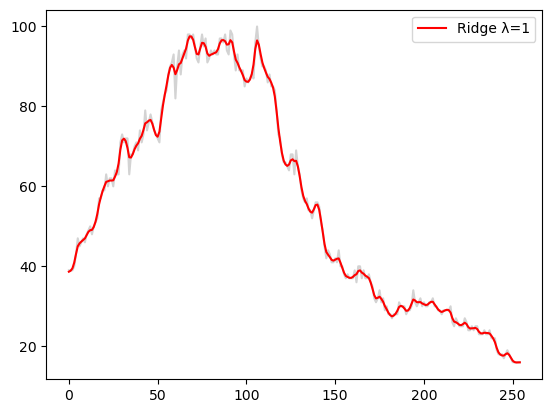

In [222]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 1)
ridge_fitted = np.dot(Xfull, b_ridge)

plt.plot(y, color='lightgray')
plt.plot(ridge_fitted, color='red', label=f'Ridge λ={1}')
plt.legend()

Choosing λ = 1 from the optimal cross validation results, error equals 4.027. The fitted ridge regression line could capture the general trend of the original data, without fully interpolating every peak and trough from the data point. Apart from capturing the general increase-then-decrease pattern, it could also capture some of the salient peak (like the one right after timesteps 100) and trough (like the one around timesteps 170-180).

## (b)

In [127]:
#perform posterior inference on the ridge regression model
C = 10**4

tau_gr = np.logspace(np.log10(0.0001), np.log10(10), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(10), 100)

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

for i in range(len(g)):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    Mat = np.linalg.inv(Q) + (Xfull.T @ Xfull)/(sig ** 2)
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    sgnQ, logcovdetQ = np.linalg.slogdet(Q)
    g.loc[i, 'logpost'] = (-n-1)*np.log(sig) - np.log(tau) - 0.5 * logcovdetQ + 0.5 * logcovdet - ((np.sum(y ** 2))/(2*(sig ** 2))) + (y.T @ Xfull @ Matinv @ Xfull.T @ y)/(2 * (sig ** 4))


In [131]:
g

,tau,sig,logpost
0,0.000100,0.1,-1.578126e+06
1,0.000112,0.1,-1.407339e+06
2,0.000126,0.1,-1.246619e+06
3,0.000142,0.1,-1.097878e+06
4,0.000159,0.1,-9.624078e+05
...,...,...,...
9995,6.280291,10.0,-7.449810e+02
9996,7.054802,10.0,-7.539586e+02
9997,7.924829,10.0,-7.635542e+02
9998,8.902151,10.0,-7.738107e+02


### (i)

In [132]:
#Posterior maximizers:
max_row = g['logpost'].idxmax()
print(max_row)
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
print(tau_opt, sig_opt)


6276
0.6892612104349695 1.7886495290574351


In [133]:
print(sig_opt**2 / tau_opt**2)

6.734150657750829


In [134]:
#check the cross validation error of lambda gaining from the posterior sample
lambda1, error1 = ridge_cv(Xfull, y, [sig_opt**2 / tau_opt**2])

In [135]:
print("The cross validation error of lambda ganing from posterior sample:",error1[sig_opt**2 / tau_opt**2])

The cross validation error of lambda ganing from posterior sample: 4.232793837940991


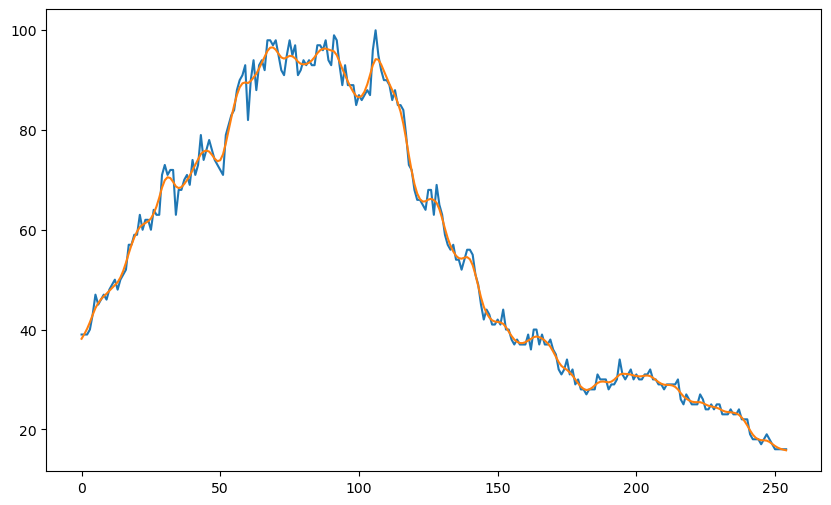

In [136]:
# Posterior mean of beta with tau_opt and sig_opt
X = Xfull
C = 10**4
tau = tau_opt
sig = sig_opt
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X.T, X)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat)
plt.show()

In [137]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

The λ given by the bayesian simulation of tau and sigma is about 6.74, and its cross validation error is a bit greater than that of 1. This indicates different optimization logic behind cross validation and bayesian simulation, where the former is purely data driven while the latter also consider a prior distribution constraint. Since the cross validation do not have a prior constraint, it will probably choose smaller λ and prone to overfit the data a bit, while the bayesian simulation will be more conservative of smaller λ and give relatively larger regulization.

### (ii)

In [138]:
N = 1000
samples = g.sample(N, weights = g['post'], replace = True)
tau_samples = np.array(samples.iloc[:,0])
sig_samples = np.array(samples.iloc[:,1])
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))
for i in range(N):
    tau = tau_samples[i]
    sig = sig_samples[i]
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    betahat = np.dot(TempMat, XTy/(sig ** 2))
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat

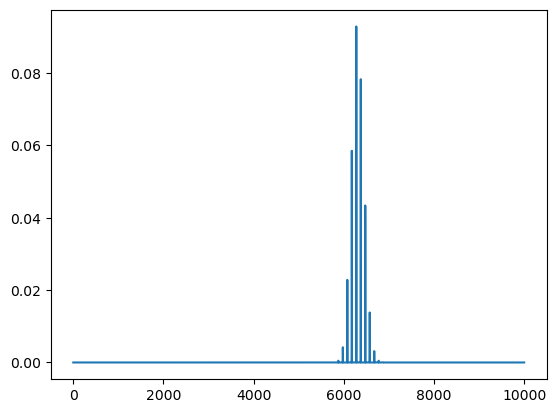

In [139]:
plt.plot(g['post'])

In [140]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

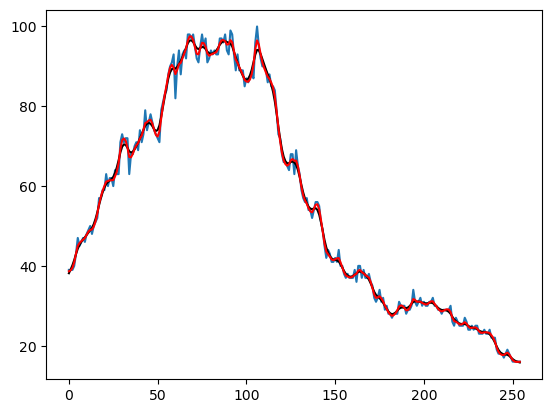

In [141]:
plt.plot(y)
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.plot(ridge_fitted, color='red', label='Ridge λ= 1, from cross validation')
plt.show()

#can see the bayesian based posterior mean is very close to the ridge regression model with lambda = 1,
#but the bayesian is smoother and seems more conservative about the prediction

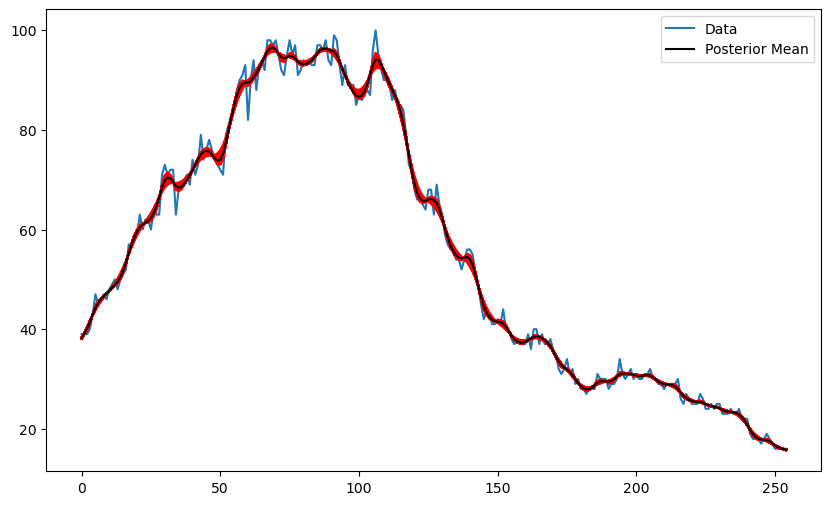

In [142]:
plt.figure(figsize = (10, 6))
plt.plot(y, label = 'Data')
for i in range(N):
    plt.plot(muhats[:,i], color = 'red')
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
plt.legend()
plt.show()


The uncertainty make sense because it could capture the general trend of the original data without fully interpolating every detail of the original data. 

### (iii)


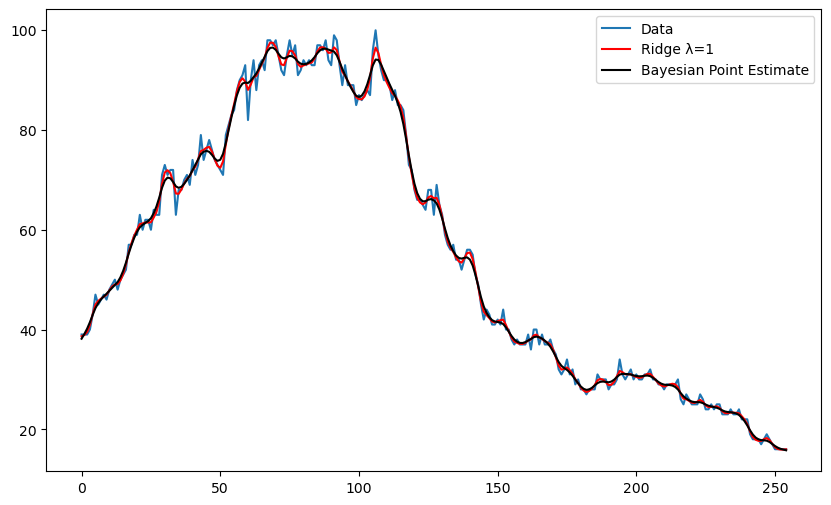

In [143]:
plt.figure(figsize = (10, 6))
plt.plot(y, label = 'Data')
plt.plot(ridge_fitted, color = 'red', label = 'Ridge λ=1')
plt.plot(mu_est, color = 'black', label = 'Bayesian Point Estimate')
plt.legend()
plt.show()

The bayesian point estimate here is smoother, and may prefer the cross validation based λ because it could better capture some of the amplitude of certain peak/trough, like the peak around timesteps 110.

# Q5

In [170]:
golf = pd.read_csv('golf.csv')

In [171]:
golf.drop(golf.index[0], inplace=True)

In [172]:
y = golf.iloc[:,0].values.astype(float)
n = len(y)

## (a)

In [173]:
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])
print(Xfull)

[[  1.   0.  -0. ...  -0.  -0.  -0.]
 [  1.   1.   0. ...  -0.  -0.  -0.]
 [  1.   2.   1. ...  -0.  -0.  -0.]
 ...
 [  1. 251. 250. ...   1.   0.  -0.]
 [  1. 252. 251. ...   2.   1.   0.]
 [  1. 253. 252. ...   3.   2.   1.]]


In [174]:
lambda_candidates = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
print(lambda_candidates)

best_lambda1, cv_errors1 = ridge_cv(Xfull, y, lambda_candidates)
print("best lambda for ridge:", best_lambda1)
print("Ridge: CV errors for each lambda:")
for lamb, error in sorted(cv_errors1.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
best lambda for ridge: 0.1
Ridge: CV errors for each lambda:
Lambda = 0.00, CV Error = 23.722012
Lambda = 0.00, CV Error = 23.622967
Lambda = 0.01, CV Error = 22.743852
Lambda = 0.10, CV Error = 18.868999
Lambda = 1.00, CV Error = 18.929202
Lambda = 10.00, CV Error = 71.351344
Lambda = 100.00, CV Error = 189.967085
Lambda = 1000.00, CV Error = 224.208263
Lambda = 10000.00, CV Error = 228.915883


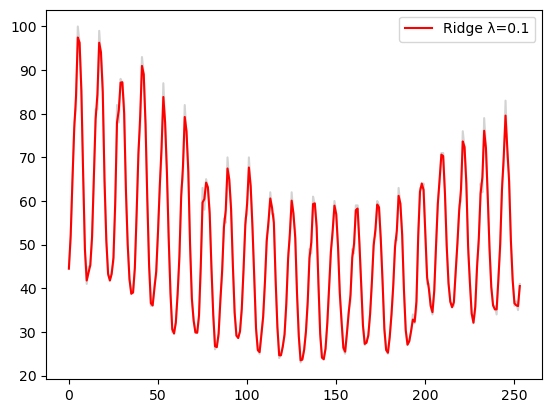

In [175]:
b_ridge = solve_ridge(Xfull, y, lambda_val = 0.1)
ridge_fitted = np.dot(Xfull, b_ridge)

plt.plot(y, color='lightgray')
plt.plot(ridge_fitted, color='red', label=f'Ridge λ={0.1}')
plt.legend()

The fitted line with optimal cv error is λ = 0.1, and the line could satisfactorily captures every oscillation of the data trend without necessarily interpolating every part of the original data.

## (b)

In [176]:
#perform posterior inference on the ridge regression model
C = 10**4

tau_gr = np.logspace(np.log10(0.0001), np.log10(10), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(10), 100)

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

for i in range(len(g)):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    Mat = np.linalg.inv(Q) + (Xfull.T @ Xfull)/(sig ** 2)
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    sgnQ, logcovdetQ = np.linalg.slogdet(Q)
    g.loc[i, 'logpost'] = (-n-1)*np.log(sig) - np.log(tau) - 0.5 * logcovdetQ + 0.5 * logcovdet - ((np.sum(y ** 2))/(2*(sig ** 2))) + (y.T @ Xfull @ Matinv @ Xfull.T @ y)/(2 * (sig ** 4))


### (i)

In [177]:
#check the cross validation error of lambda gaining from the posterior sample
lambda1, error1 = ridge_cv(Xfull, y, [sig_opt**2 / tau_opt**2])

In [178]:
print("The cross validation error of lambda ganing from posterior sample:",error1[sig_opt**2 / tau_opt**2])

The cross validation error of lambda ganing from posterior sample: 18.026723973952965


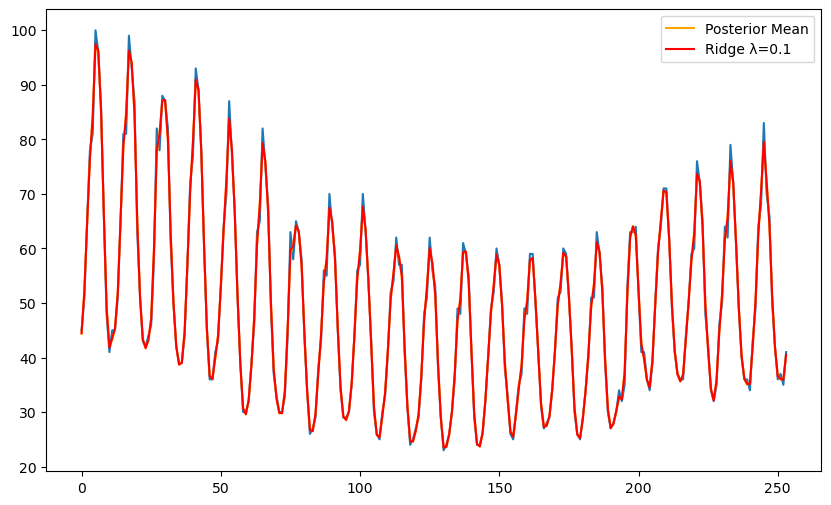

In [179]:
# Posterior mean of beta with tau_opt and sig_opt
X = Xfull
C = 10**4
tau = tau_opt
sig = sig_opt
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))

XTX = np.dot(X.T, X)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat, color = 'orange', label = 'Posterior Mean')
plt.plot(ridge_fitted, color='red', label=f'Ridge λ={0.1}')
plt.legend()
plt.show()

In [180]:
#Posterior maximizers:
max_row = g['logpost'].idxmax()
print(max_row)
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
print(tau_opt, sig_opt)

print(sig_opt**2 / tau_opt**2)

6995
6.280291441834247 2.4770763559917115
0.15556761439304756


The λ obtained by the bayesian simulation of sigma squared and tau squared is 0.156, a bit greater than the cross validation based λ. It can also capture the frequency of oscilation in the original dataset as the cross validation based λ = 1 could do. In addtion to this, the bayesian simulated λ model perform better at approximating the magnitudes of oscilation at peaks and troughts.

### (ii)

In [181]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

In [182]:
N = 1000
samples = g.sample(N, weights = g['post'], replace = True)
tau_samples = np.array(samples.iloc[:,0])
sig_samples = np.array(samples.iloc[:,1])
betahats = np.zeros((n, N))
muhats = np.zeros((n, N))
for i in range(N):
    tau = tau_samples[i]
    sig = sig_samples[i]
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n-2)]))
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    betahat = np.dot(TempMat, XTy/(sig ** 2))
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat

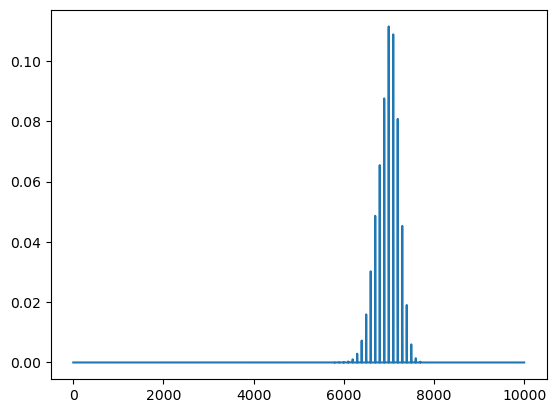

In [183]:
plt.plot(g['post'])

In [184]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

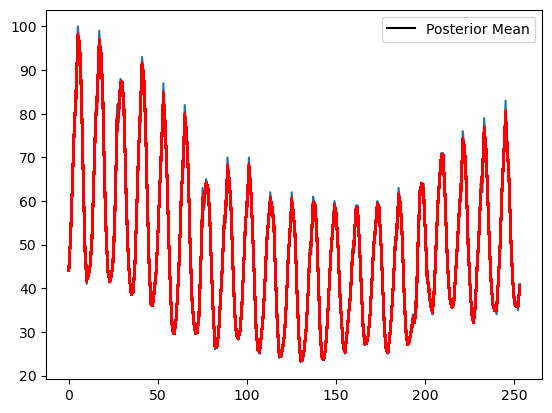

In [187]:
plt.plot(y)
plt.plot(mu_est, color = 'black', label = 'Posterior Mean')
for i in range(N):
    plt.plot(muhats[:,i], color = 'red')
plt.legend()
plt.show()

The uncertainty revealed in the plot makes sense because all of them align with the variability of original data (the frequency of oscilation and the relative amplitude of each peak/trough).

### (iii)

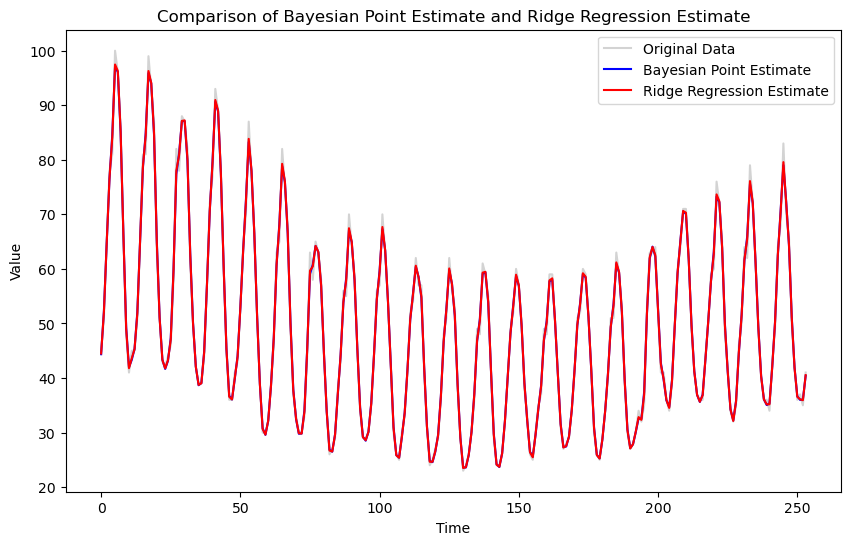

In [186]:
# Plot the Bayesian point estimate and the ridge regression estimate
plt.figure(figsize=(10, 6))
plt.plot(y, label='Original Data', color='lightgray')
plt.plot(mu_est, label='Bayesian Point Estimate', color='blue')
plt.plot(ridge_fitted, label='Ridge Regression Estimate', color='red')
plt.legend()
plt.title('Comparison of Bayesian Point Estimate and Ridge Regression Estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Both two lines seems not differ from each other too much.

# Q6
## (a)

In [224]:
golf = pd.read_csv('golf.csv')
golf.drop(golf.index[0], inplace=True)
y = golf.iloc[:,0].values.astype(float)
n = len(y)

In [225]:
#construct the Xfull based on the model
x = np.arange(1, n+1)
Xfull = np.column_stack([np.ones(n), x-1])
for i in range(n-2):
    c = i+2
    xc = ((x > c).astype(float))*(x-c)
    Xfull = np.column_stack([Xfull, xc])

Xfull = np.column_stack([Xfull, np.cos(1/6 * np.pi * x), np.sin(1/6 * np.pi * x)])
print(Xfull)

[[ 1.00000000e+00  0.00000000e+00 -0.00000000e+00 ... -0.00000000e+00
   8.66025404e-01  5.00000000e-01]
 [ 1.00000000e+00  1.00000000e+00  0.00000000e+00 ... -0.00000000e+00
   5.00000000e-01  8.66025404e-01]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00 ... -0.00000000e+00
   6.12323400e-17  1.00000000e+00]
 ...
 [ 1.00000000e+00  2.51000000e+02  2.50000000e+02 ... -0.00000000e+00
   1.00000000e+00 -2.64597986e-14]
 [ 1.00000000e+00  2.52000000e+02  2.51000000e+02 ...  0.00000000e+00
   8.66025404e-01  5.00000000e-01]
 [ 1.00000000e+00  2.53000000e+02  2.52000000e+02 ...  1.00000000e+00
   5.00000000e-01  8.66025404e-01]]


In [226]:
lambda_candidates = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
print(lambda_candidates)

best_lambda1, cv_errors1 = ridge_cv(Xfull, y, lambda_candidates)
print("best lambda for ridge:", best_lambda1)
print("Ridge: CV errors for each lambda:")
for lamb, error in sorted(cv_errors1.items()):
    print(f"Lambda = {lamb:.2f}, CV Error = {error:.6f}")

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
best lambda for ridge: 1.0
Ridge: CV errors for each lambda:
Lambda = 0.00, CV Error = 23.312018
Lambda = 0.00, CV Error = 23.212237
Lambda = 0.01, CV Error = 22.326172
Lambda = 0.10, CV Error = 18.381307
Lambda = 1.00, CV Error = 15.891789
Lambda = 10.00, CV Error = 19.405111
Lambda = 100.00, CV Error = 67.891985
Lambda = 1000.00, CV Error = 189.074221
Lambda = 10000.00, CV Error = 224.781297


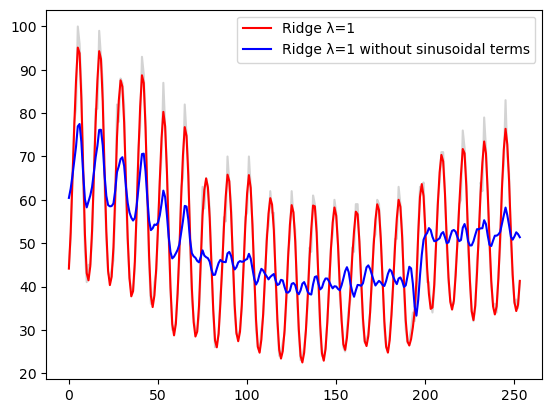

In [239]:
#choose the optimal ridge lambda
optimal_ridge_lambda = 1
b_ridge = solve_ridge(Xfull, y, lambda_val = optimal_ridge_lambda)
ridge_fitted = np.dot(Xfull, b_ridge)

#change slope model
Xfull_change_slope = Xfull[:, :-2]
b_ridge_change_slope = b_ridge[:-2]
ridge_fitted_change_slope = np.dot(Xfull_change_slope, b_ridge_change_slope)

plt.plot(y, color='lightgray')
plt.plot(ridge_fitted, color='red', label=f'Ridge λ={1}')
plt.plot(ridge_fitted_change_slope, color='blue', label=f'Ridge λ={1} without sinusoidal terms')
plt.legend()

Gaining λ = 1 from the cross-validation result for its smallest cross validation value: 15.89, and the fitted line could capture the frequency of oscillation in the original dataset well while also capturing most of the relative amplitudes of peaks and troughs. Without the sinusoidal term, the fitted line perform worse for capturing the oscillation and also the amplitude of peaks/troughs.

## (b)

In [240]:
#perform posterior inference on the ridge regression model
C = 10**4

tau_gr = np.logspace(np.log10(0.0001), np.log10(10), 100)
sig_gr = np.logspace(np.log10(0.1), np.log10(10), 100)

t, s = np.meshgrid(tau_gr, sig_gr)

g = pd.DataFrame({'tau': t.flatten(), 'sig': s.flatten()})

for i in range(len(g)):
    tau = g.loc[i, 'tau']
    sig = g.loc[i, 'sig']
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n - 2), [C, C]]))
    Mat = np.linalg.inv(Q) + (Xfull.T @ Xfull)/(sig ** 2)
    Matinv = np.linalg.inv(Mat)
    sgn, logcovdet = np.linalg.slogdet(Matinv)
    sgnQ, logcovdetQ = np.linalg.slogdet(Q)
    g.loc[i, 'logpost'] = (-n-1)*np.log(sig) - np.log(tau) - 0.5 * logcovdetQ + 0.5 * logcovdet - ((np.sum(y ** 2))/(2*(sig ** 2))) + (y.T @ Xfull @ Matinv @ Xfull.T @ y)/(2 * (sig ** 4))


### (i)

In [242]:
#check the cross validation error of lambda gaining from the posterior sample
lambda1, error1 = ridge_cv(Xfull, y, [sig_opt**2 / tau_opt**2])
print("The cross validation error of lambda ganing from posterior sample:",error1[sig_opt**2 / tau_opt**2])

The cross validation error of lambda ganing from posterior sample: 23.307704037136283


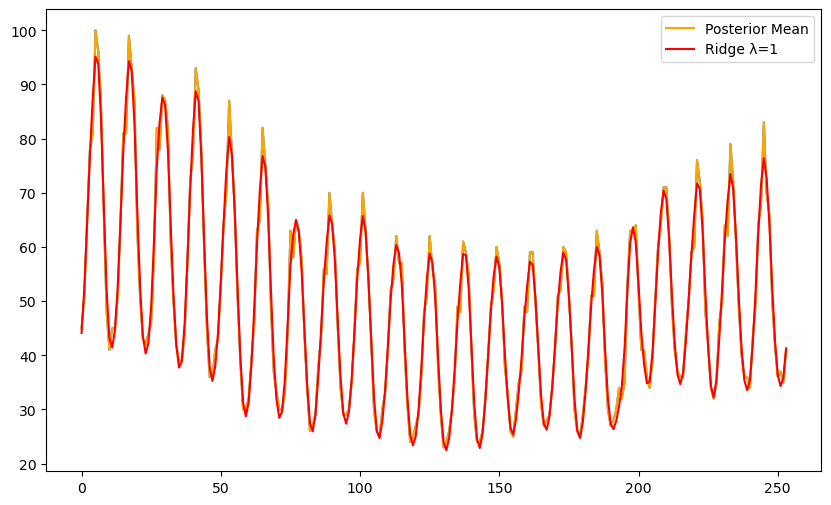

In [243]:
# Posterior mean of beta with tau_opt and sig_opt
X = Xfull
C = 10**4
tau = tau_opt
sig = sig_opt
Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n - 2), [C, C]]))

XTX = np.dot(X.T, X)
TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
XTy = np.dot(X.T, y)

betahat = np.dot(TempMat, XTy/(sig ** 2))
muhat = np.dot(X, betahat)

plt.figure(figsize = (10, 6))
plt.plot(y)
plt.plot(muhat, color = 'orange', label = 'Posterior Mean')
plt.plot(ridge_fitted, color='red', label=f'Ridge λ={1}')
plt.legend()
plt.show()

In [244]:
#Posterior maximizers:
max_row = g['logpost'].idxmax()
print(max_row)
tau_opt = g.loc[max_row, 'tau']
sig_opt = g.loc[max_row, 'sig']
print(tau_opt, sig_opt)

print(sig_opt**2 / tau_opt**2)

299
10.0 0.10974987654930562
0.00012045035402587825


The estimate from calculating the sigma squared devided by tau squared is 0.00012, which is nearly no regularization at all.

### (ii)

In [246]:
g['post'] = np.exp(g['logpost'] - np.max(g['logpost']))
g['post'] = g['post']/np.sum(g['post'])

In [250]:
# N = 1000
# samples = g.sample(N, weights = g['post'], replace = True)
# tau_samples = np.array(samples.iloc[:,0])
# sig_samples = np.array(samples.iloc[:,1])
# betahats = np.zeros((n + 2, N))
# muhats = np.zeros((n, N))
# for i in range(N):
#     tau = tau_samples[i]
#     sig = sig_samples[i]
#     Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n)]))
#     XTX = np.dot(X.T, X)
#     TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
#     XTy = np.dot(X.T, y)
#     betahat = np.dot(TempMat, XTy/(sig ** 2))
#     muhat = np.dot(X, betahat)
#     betahats[:,i] = betahat
#     muhats[:,i] = muhat

#only sample from the first n - 2 betas

N = 1000
samples = g.sample(N, weights = g['post'], replace = True)
tau_samples = np.array(samples.iloc[:,0])
sig_samples = np.array(samples.iloc[:,1])
betahats = np.zeros((n + 2, N))
muhats = np.zeros((n, N))
for i in range(N):
    tau = tau_samples[i]
    sig = sig_samples[i]
    Q = np.diag(np.concatenate([[C, C], np.repeat(tau**2, n - 2), [C, C]]))
    XTX = np.dot(X.T, X)
    TempMat = np.linalg.inv(np.linalg.inv(Q) + (XTX/(sig ** 2)))
    XTy = np.dot(X.T, y)
    betahat = np.dot(TempMat, XTy/(sig ** 2))
    muhat = np.dot(X, betahat)
    betahats[:,i] = betahat
    muhats[:,i] = muhat

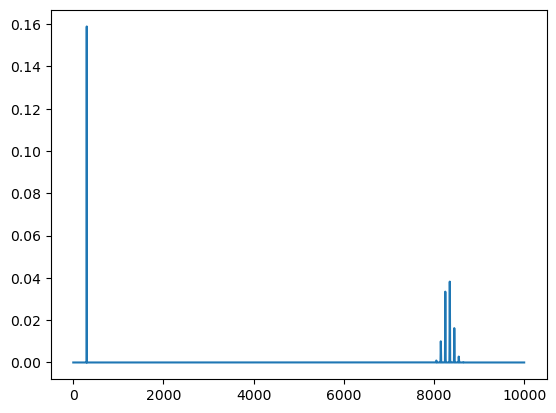

In [248]:
plt.plot(g['post'])

In [235]:
beta_est = np.mean(betahats, axis = 1)
mu_est = np.mean(muhats, axis = 1) #these are the fitted values

In [253]:
muhat_without_sin = np.dot(Xfull_change_slope, betahats[:-2])
mu_est_without_sin = np.mean(muhat_without_sin, axis = 1)

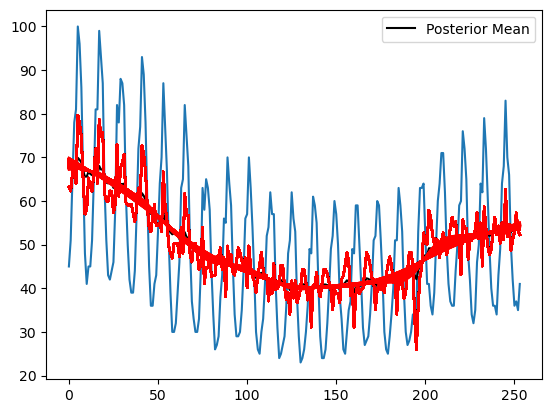

In [255]:
plt.plot(y)
plt.plot(mu_est_without_sin, color = 'black', label = 'Posterior Mean')
for i in range(N):
    plt.plot(muhat_without_sin[:,i], color = 'red')
plt.legend()
plt.show()

Most of the values from the posterior samples are of very small amplitude and seems to have much noise in their oscialltion, fail to capture the frequency of fluctutation in the original dataset. This uncertainty might reflect the influence of not including the sinusoidal part in the model such that the periodicity cannot be satisfactorily taken into account of.

### (iii)

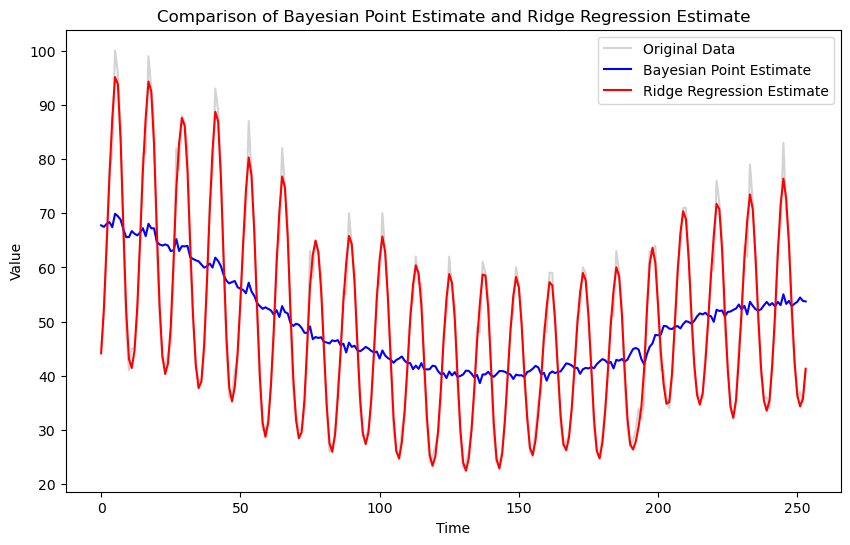

In [256]:
# Plot the Bayesian point estimate and the ridge regression estimate
plt.figure(figsize=(10, 6))
plt.plot(y, label='Original Data', color='lightgray')
plt.plot(mu_est_without_sin, label='Bayesian Point Estimate', color='blue')
plt.plot(ridge_fitted, label='Ridge Regression Estimate', color='red')
plt.legend()
plt.title('Comparison of Bayesian Point Estimate and Ridge Regression Estimate')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Ridge regression estimate from cross validation λ = 1 is smoother, capturing the original frequency and amplitude well, while the bayesian point estimate has a lot of noise and small fluctuation periods. So it may be better to choose the λ = 1 ridge regression estimator.